In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import cv2 

%matplotlib inline
import matplotlib.pyplot as plt

import os
import math
from utils.dataloaders import full_onera_loader, stretch_8bit

import rasterio

In [3]:
DROPOUT = 0.0

class UNetBlock(nn.Module):
    def __init__(self, filters_in, filters_out):
        super().__init__()
        self.filters_in = filters_in
        self.filters_out = filters_out
        self.conv1 = nn.Conv2d(filters_in, filters_out, (3, 3), padding=1)
        self.norm1 = nn.BatchNorm2d(filters_out)
        self.conv2 = nn.Conv2d(filters_out, filters_out, (3, 3), padding=1)
        self.norm2 = nn.BatchNorm2d(filters_out)

        self.activation = nn.ReLU()

    def forward(self, x):
        conved1 = self.conv1(x)
        conved1 = self.activation(conved1)
        conved1 = self.norm1(conved1)
        conved2 = self.conv2(conved1)
        conved2 = self.activation(conved2)
        conved2 = self.norm2(conved2)
        return conved2

class UNetDownBlock(UNetBlock):
    def __init__(self, filters_in, filters_out, pool=True):
        super().__init__(filters_in, filters_out)
        if pool:
            self.pool = nn.MaxPool2d(2)
        else:
            self.pool = lambda x: x

    def forward(self, x):
        return self.pool(super().forward(x))

class UNetUpBlock(UNetBlock):
    def __init__(self, filters_in, filters_out):
        super().__init__(filters_in, filters_out)
        self.upconv = nn.Conv2d(filters_in, filters_in // 2, (3, 3), padding=1)
        self.upnorm = nn.BatchNorm2d(filters_in // 2)

    def forward(self, x, cross_x1, cross_x2):
        x = F.upsample(x, size=cross_x1.size()[-2:], mode='bilinear')
        x = self.upnorm(self.activation(self.upconv(x)))
        x = torch.cat((x, self.activation(cross_x1*cross_x2)), 1)
        return super().forward(x)

class UNet(nn.Module):
    def __init__(self, layers, init_filters):
        super().__init__()
        self.down_layers = nn.ModuleList()
        self.up_layers = nn.ModuleList()
        self.init_filters = init_filters

        filter_size = init_filters
        for _ in range(layers - 1):
            self.down_layers.append(
                UNetDownBlock(filter_size, filter_size*2)
            )
            filter_size *= 2
        self.down_layers.append(UNetDownBlock(filter_size, filter_size * 2, pool=False))
        for i in range(layers):
            self.up_layers.append(
                UNetUpBlock(filter_size * 2, filter_size)
            )
            filter_size //= 2

        self.data_norm = nn.BatchNorm2d(4)
        self.init_layer = nn.Conv2d(4, init_filters, (7, 7), padding=3)
        self.activation = nn.ReLU()
        self.init_norm = nn.BatchNorm2d(init_filters)
        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x1, x2):
        x1 = self.data_norm(x1)
        x1 = self.init_norm(self.activation(self.init_layer(x1)))

        x2 = self.data_norm(x2)
        x2 = self.init_norm(self.activation(self.init_layer(x2)))
        
        saved_x = [[x1, x2]]
        for layer in self.down_layers:
            saved_x.append([x1,x2])
            x1 = self.dropout(layer(x1))
            x2 = self.dropout(layer(x2))
        
        saved_x_copy = saved_x
        is_first = True
        for layer, saved_x in zip(self.up_layers, reversed(saved_x)):
            if not is_first:
                is_first = False
                x1 = self.dropout(x1)
            x1 = layer(x1, saved_x[0], saved_x[1])
        return x1, saved_x_copy

class UNetClassify(UNet):
    def __init__(self, *args, **kwargs):
#         init_val = kwargs.pop('init_val', 0.5)
        super().__init__(*args, **kwargs)
        self.output_layer = nn.Conv2d(self.init_filters, 1, (3, 3), padding=1)

#         for name, param in self.named_parameters():
#             typ = name.split('.')[-1]
#             if typ == 'bias':
#                 if 'output_layer' in name:
#                     # Init so that the average will end up being init_val
#                     param.data.fill_(-math.log((1-init_val)/init_val))
#                 else:
#                     param.data.zero_()

    def forward(self, x1, x2):
        x = super().forward(x1, x2)
        # Note that we don't perform the sigmoid here.
        return self.output_layer(x[0]), x[1]

In [4]:
# model = torch.load('../weights/onera/3dconv_seg.pt')
model = UNetClassify(layers=5, init_filters=32).cuda()
weights = torch.load('../weights/onera/unet_siamese_prod_relu_inp32_4band_2dates_focal_hm.pt')
model.load_state_dict(weights)
model.eval()

UNetClassify(
  (down_layers): ModuleList(
    (0): UNetDownBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): UNetDownBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, pa

In [5]:
dataset = full_onera_loader('../datasets/onera/', ['B02','B03','B04','B08'])

In [7]:
dataset.keys()

dict_keys(['bercy', 'paris', 'mumbai', 'bordeaux', 'hongkong', 'nantes', 'rennes', 'aguasclaras', 'beirut', 'pisa', 'beihai', 'abudhabi', 'saclay_e', 'cupertino'])

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


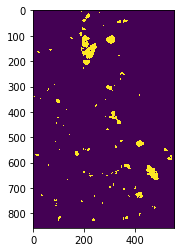

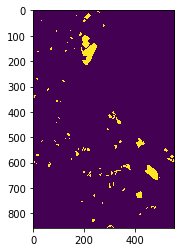

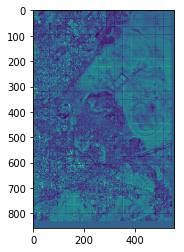

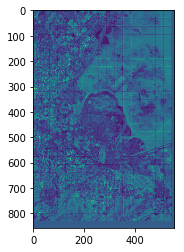

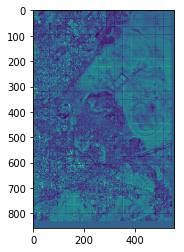

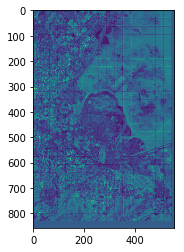

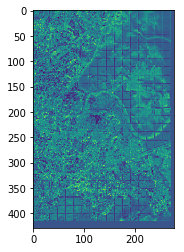

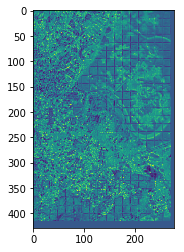

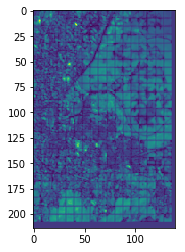

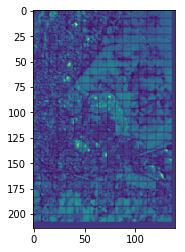

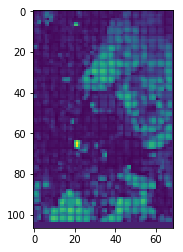

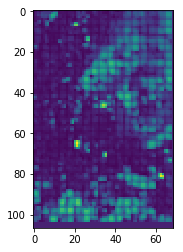

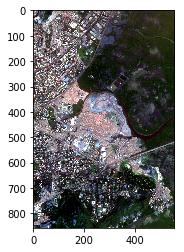

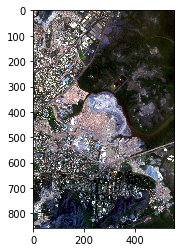

In [8]:
input_size = 32
for city in dataset.keys():
    fig, axes = plt.subplots(2,7)
    img = dataset[city]['images']
    label = dataset[city]['labels']
    out = np.zeros((img.shape[2],img.shape[3]))
    outs1_1 = np.zeros((32,img.shape[2], img.shape[3]))
    outs2_1 = np.zeros((32,img.shape[2], img.shape[3]))
    outs3_1 = np.zeros((64,img.shape[2]//2, img.shape[3]//2))
    outs4_1 = np.zeros((128,img.shape[2]//4, img.shape[3]//4))
    outs5_1 = np.zeros((256,img.shape[2]//8, img.shape[3]//8))
    
    outs1_2 = np.zeros((32,img.shape[2], img.shape[3]))
    outs2_2 = np.zeros((32,img.shape[2], img.shape[3]))
    outs3_2 = np.zeros((64,img.shape[2]//2, img.shape[3]//2))
    outs4_2 = np.zeros((128,img.shape[2]//4, img.shape[3]//4))
    outs5_2 = np.zeros((256,img.shape[2]//8, img.shape[3]//8))
    
    for i in range(0,img.shape[2]//32):
        for j in range(0,img.shape[3]//32):
            if i*32 + input_size < img.shape[2] and j*32 + input_size < img.shape[3]:
                patch = np.transpose(img[:, : ,i*32:i*32+input_size, j*32:j*32+input_size], (1,0,2,3))
                inp1 = torch.from_numpy(np.asarray([patch[0]])).cuda()
                inp2 = torch.from_numpy(np.asarray([patch[1]])).cuda()
                logits = model(inp1, inp2)
#                 print (logits.min(),logits.max())
                pred = F.sigmoid(logits[0]) > 0.5
                pred = pred.data.cpu().numpy()[0]
                out[i*32:i*32+input_size,j*32:j*32+input_size] = pred    
#                 print (logits[1][0][0].size())
#                 print (logits[1][1][0].size())
#                 print (logits[1][2][0].size())
#                 print (logits[1][3][0].size())
#                 print (logits[1][4][0].size())
                outs1_1[:,i*32:i*32+input_size,j*32:j*32+input_size] = logits[1][0][0][0].data.cpu().numpy()
                outs2_1[:,i*32:i*32+input_size,j*32:j*32+input_size] = logits[1][1][0][0].data.cpu().numpy()
                outs3_1[:,i*16:i*16+input_size//2,j*16:j*16+input_size//2] = logits[1][2][0][0].data.cpu().numpy()
                outs4_1[:,i*8:i*8+input_size//4,j*8:j*8+input_size//4] = logits[1][3][0][0].data.cpu().numpy()
                outs5_1[:,i*4:i*4+input_size//8,j*4:j*4+input_size//8] = logits[1][4][0][0].data.cpu().numpy()
                
                outs1_2[:,i*32:i*32+input_size,j*32:j*32+input_size] = logits[1][0][1][0].data.cpu().numpy()
                outs2_2[:,i*32:i*32+input_size,j*32:j*32+input_size] = logits[1][1][1][0].data.cpu().numpy()
                outs3_2[:,i*16:i*16+input_size//2,j*16:j*16+input_size//2] = logits[1][2][1][0].data.cpu().numpy()
                outs4_2[:,i*8:i*8+input_size//4,j*8:j*8+input_size//4] = logits[1][3][1][0].data.cpu().numpy()
                outs5_2[:,i*4:i*4+input_size//8,j*4:j*4+input_size//8] = logits[1][4][1][0].data.cpu().numpy()
    plt.imshow(out)
    plt.show()
    plt.imshow(label)
    plt.show()
    plt.imshow(outs1_1.mean(0))
    plt.show()
    plt.imshow(outs1_2.mean(0))
    plt.show()
    plt.imshow(outs2_1.mean(0))
    plt.show()
    plt.imshow(outs2_2.mean(0))
    plt.show()
    plt.imshow(outs3_1.mean(0))
    plt.show()
    plt.imshow(outs3_2.mean(0))
    plt.show()
    plt.imshow(outs4_1.mean(0))
    plt.show()
    plt.imshow(outs4_2.mean(0))
    plt.show()
    plt.imshow(outs5_1.mean(0))
    plt.show()
    plt.imshow(outs5_2.mean(0))
    plt.show()
    rgb1 = cv2.merge([img[0][0], img[1][0], img[2][0]])
    rgb2 = cv2.merge([img[0][1], img[1][1], img[2][1]])
    plt.imshow(rgb1)
    plt.show()
    plt.imshow(rgb2)
    plt.show()
    break

In [59]:
i, j, out.shape, outs1_1.shape, outs2_1.shape, outs3_1.shape, outs4_1.shape, outs5_1.shape

(384,
 384,
 (408, 390),
 (16, 408, 390),
 (16, 408, 390),
 (32, 204, 195),
 (64, 102, 97),
 (128, 51, 48))

In [9]:
abus2_d1_path = '../datasets/onera/images/abudhabi/cropped_safes/20151204T070252/'
abus2_d2_path = '../datasets/onera/images/abudhabi/cropped_safes/20181009T065801/'




In [10]:
d1_b2_r = rasterio.open(abus2_d1_path + 'B02.tif')
d1_b3_r = rasterio.open(abus2_d1_path + 'B03.tif')
d1_b4_r = rasterio.open(abus2_d1_path + 'B04.tif')
d1_b8_r = rasterio.open(abus2_d1_path + 'B08.tif')

d2_b2_r = rasterio.open(abus2_d2_path + 'B02.tif')
d2_b3_r = rasterio.open(abus2_d2_path + 'B03.tif')
d2_b4_r = rasterio.open(abus2_d2_path + 'B04.tif')
d2_b8_r = rasterio.open(abus2_d2_path + 'B08.tif')


In [11]:
d1_b2 = stretch_8bit(d1_b2_r.read()[0], 2, 98)
d1_b3 = stretch_8bit(d1_b3_r.read()[0], 2, 98)
d1_b4 = stretch_8bit(d1_b4_r.read()[0], 2, 98)
d1_b8 = stretch_8bit(d1_b8_r.read()[0], 2, 98)

d2_b2 = stretch_8bit(d2_b2_r.read()[0], 2, 98)
d2_b3 = stretch_8bit(d2_b3_r.read()[0], 2, 98)
d2_b4 = stretch_8bit(d2_b4_r.read()[0], 2, 98)
d2_b8 = stretch_8bit(d2_b8_r.read()[0], 2, 98)

In [12]:
inp1 = np.asarray([[d1_b2, d1_b3, d1_b4, d1_b8]]).astype(np.float32) / 255.
inp2 = np.asarray([[d2_b2, d2_b3, d2_b4, d2_b8]]).astype(np.float32) / 255.

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


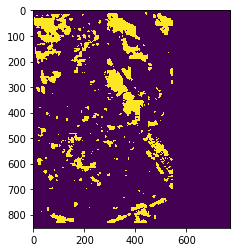

In [14]:
out = np.zeros((inp1.shape[2], inp2.shape[3]))
for i in range(0,img.shape[2],32):
    for j in range(0,img.shape[3],32):
        if i + 32 < img.shape[2] and j + 32 < img.shape[3]:
            p1 = torch.from_numpy(inp1[:,:,i:i+32,j:j+32]).cuda()
            p2 = torch.from_numpy(inp2[:,:,i:i+32,j:j+32]).cuda()
            logits = model(p1, p2)
#                 print (logits.min(),logits.max())
            pred = F.sigmoid(logits[0]) > 0.5
            pred = pred.data.cpu().numpy()[0]
            out[i:i+32,j:j+32] = pred     
plt.imshow(out)
plt.show()

In [15]:
d1_path = '../../Yiwu/SAFES/S2A_MSIL1C_20151126T024032_N0204_R089_T50RQT_20170228T133751.SAFE/GRANULE/S2A_OPER_MSI_L1C_TL_EPA__20170228T092218_A002231_T50RQT_N02.04/IMG_DATA/S2A_OPER_MSI_L1C_TL_EPA__20170228T092218_A002231_T50RQT_'
d1b2_r = rasterio.open(d1_path + 'B02.jp2')
d1b3_r = rasterio.open(d1_path + 'B03.jp2')
d1b4_r = rasterio.open(d1_path + 'B04.jp2')
d1b8_r = rasterio.open(d1_path + 'B08.jp2')

d2_path = '../../Yiwu/SAFES/S2B_MSIL1C_20180419T023549_N0206_R089_T50RQT_20180419T051329.SAFE/GRANULE/L1C_T50RQT_A005835_20180419T024752/IMG_DATA/T50RQT_20180419T023549_'
d2b2_r = rasterio.open(d2_path + 'B02.jp2')
d2b3_r = rasterio.open(d2_path + 'B03.jp2')
d2b4_r = rasterio.open(d2_path + 'B04.jp2')
d2b8_r = rasterio.open(d2_path + 'B08.jp2')

In [16]:
d1_b2 = stretch_8bit(d1b2_r.read()[0])
d1_b3 = stretch_8bit(d1b3_r.read()[0])
d1_b4 = stretch_8bit(d1b4_r.read()[0])
d1_b8 = stretch_8bit(d1b8_r.read()[0])

d2_b2 = stretch_8bit(d1b2_r.read()[0])
d2_b3 = stretch_8bit(d1b3_r.read()[0])
d2_b4 = stretch_8bit(d1b4_r.read()[0])
d2_b8 = stretch_8bit(d1b8_r.read()[0])

In [17]:
d1_stack = np.asarray([d1_b2,d1_b3,d1_b4,d1_b8]).astype(np.float32) / 255.
d2_stack = np.asarray([d2_b2,d2_b3,d2_b4,d2_b8]).astype(np.float32) / 255.

In [18]:
batches1 = []
batches2 = []
input_size = 32
for i in range(0,d1_b2.shape[0],input_size):
    for j in range(0,d1_b2.shape[1],input_size):
        if i + input_size < d1_b2.shape[0] and j + input_size < d1_b2.shape[1]:
            batches1.append(d1_stack[:,i:i+input_size,j:j+input_size])
            batches2.append(d2_stack[:,i:i+input_size,j:j+input_size])

In [20]:
outs = []

for k in range(0,len(batches1),200):
    inp1 = torch.from_numpy(np.asarray(batches1[k:k+200])).cuda()
    inp2 = torch.from_numpy(np.asarray(batches2[k:k+200])).cuda()
    logits = model(inp1, inp2)
    pred = F.sigmoid(logits[0])
    pred = pred.data.cpu().numpy()
    outs += list(pred)
    
    if len(outs) % 10000 == 0:
        print (len(outs))

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000


In [21]:
out = np.zeros((d1_b2.shape[0],d1_b2.shape[1]))

In [22]:
k = 0
for i in range(0, d1_b2.shape[0], input_size):
    for j in range(0, d1_b2.shape[1], input_size):
        if i+input_size < d1_b2.shape[0] and j+input_size < d1_b2.shape[1]:
            out[i:i+input_size, j:j+input_size] = outs[k]
            k += 1

In [23]:
len(outs)

117649

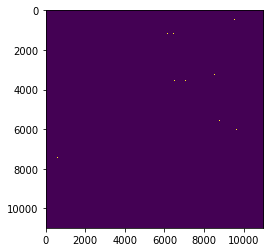

In [28]:
plt.imshow(out>0.5)

cv2.imwrite('yiwu_out.png', (out > 0.1) * 255)

In [29]:
cv2.imwrite('yiwu_out.png', (out > 0.5) * 255)

True